In [1]:
import csv
import os
import re
from datetime import datetime

import bert
import nltk
import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.tokenize import word_tokenize
from official.nlp import optimization
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tqdm import tqdm

In [2]:
# Include this block so that keras 
# # would not use up all the GPU memory.
# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
OUTPUT_DIR = './model/'
datafiles_path = './data/drug_sentence_classification.csv'
data_files = pd.read_csv(datafiles_path)

In [5]:
data_files.head()

,neutral_citation,sentence_id,important,sentence
0,[2009] HKCFI 2104,0,False,"## HKSAR v. MWANIKI, CATHERINE WAITHIRA [2009..."
1,[2009] HKCFI 2104,1,False,HCCC241/2008
2,[2009] HKCFI 2104,2,False,IN THE HIGH COURT OF THE
3,[2009] HKCFI 2104,3,False,HONG KONG SPECIAL ADMINISTRATIVE REGION
4,[2009] HKCFI 2104,4,False,COURT OF FIRST INSTANCE


In [6]:
#Clean up the data

#Function to clean up data
#•Only take characters inside A-Za-z
#•remove stop words
#•lemmatize

In [7]:
def cleanUpSentence(r):
    strip_special_chars = re.compile("[^A-Za-z0-9, ]+")
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    words = word_tokenize(r)
    filtered_sentence = []
    for w in words:
        if any(map(str.isdigit, w)):
            filtered_sentence.append("0")
        elif w:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence),len(filtered_sentence)

In [8]:
def clean_data(datas_X,datas_Y):    
    totalX = []
    totalY = np.array(datas_Y).reshape((-1,1))
    maxLength = 0
    with tqdm(total=datas_X.shape[0], unit_scale=True) as pbar:
        for i, doc in enumerate(datas_X):
            #直接在这里去除\n，防止\n可能会让两句话连接处的两个单词连在一起
            doc = doc.replace("\n"," ")
            sent,sent_len = cleanUpSentence(doc)
            maxLength = max(maxLength,sent_len)
            totalX.append(sent)
            pbar.update()
    print("max input length is: ",maxLength)
    totalX=np.array(totalX)
    return totalX,totalY,maxLength

In [9]:
def preprocess(data_df,train_frac=0.8,neg_resample_frac=0.25):
    totalX,totalY,maxLength = clean_data(data_df['sentence'],data_df['important'].astype(int))
    empty_pred = data_files[totalX==''].reset_index(drop=True)
    empty_pred['important'] = [False] * empty_pred.shape[0]
    total_df = data_files[totalX!=''][['neutral_citation','sentence_id']].reset_index(drop=True)
    total_df['X'],total_df['Y'] = totalX[totalX!=''],totalY[totalX!='']
    pos_df,neg_df = total_df[total_df['Y'] != 0],total_df[total_df['Y'] == 0]
    print("positive sample size: ", pos_df.shape[0])
    train_pos,test_pos = train_test_split(pos_df,train_size=train_frac,random_state=1)
    train_neg,test_neg = train_test_split(neg_df,train_size=train_frac*neg_resample_frac,random_state=1)
    train_df = train_pos.append(train_neg).sample(frac=1).reset_index(drop=True)
    test_df = test_pos.append(test_neg).sample(frac=1).reset_index(drop=True)
    return empty_pred,train_df,test_df,maxLength

In [10]:
empty_pred,train_df,test_df,maxLength = preprocess(data_files,neg_resample_frac=1)
train_df

100%|██████████| 299k/299k [00:49<00:00, 6.06kit/s] 


max input length is:  267
positive sample size:  66978


,neutral_citation,sentence_id,X,Y
0,[2018] HKDC 282,111,"0 has 0 previous convictions , of which nine a...",1
1,[2018] HKCFI 1400,1,hccc 0,0
2,[2013] HKCFI 680,1,hccc 0,0
3,[2009] HKDC 1508,33,"very properly , he quotes the case of secretar...",1
4,[2014] HKCFI 2238,124,i adopt a starting point of 0 months,0
...,...,...,...,...
212904,[2011] HKCFI 1229,41,"so far as the possession charge is concerned ,...",0
212905,[2018] HKCFI 1788,45,he and his cohabitee has a son born three days...,1
212906,[2017] HKDC 447,44,0,0
212907,[2019] HKDC 458,32,the police also found on the defendant an elec...,0


In [11]:
empty_pred

,neutral_citation,sentence_id,important,sentence
0,[2009] HKCFI 2104,6,False,> \----------------------
1,[2009] HKCFI 2104,8,False,> \----------------------
2,[2009] HKCFI 2105,6,False,> \----------------------
3,[2009] HKCFI 2105,8,False,> \----------------------
4,[2009] HKCFI 2105,42,False,>
...,...,...,...,...
32560,[2012] HKCFI 1705,59,False,>
32561,[2012] HKCFI 795,6,False,\-----------------
32562,[2012] HKCFI 795,8,False,\-----------------
32563,[2012] HKCFI 795,10,False,\---------------------------------


In [12]:
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_all_sentences(sentences, tokenizer, max_seq_len=20):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    with tqdm(total=sentences.shape[0], unit_scale=True) as pbar:
        for sentence in sentences:
            input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
            all_input_ids.append(input_ids)
            all_input_mask.append(input_mask)
            all_segment_ids.append(segment_ids)
            pbar.update()
    return np.array(all_input_ids), np.array(all_input_mask), np.array(all_segment_ids)

In [13]:
VOCAB_FILE = 'bert_uncased_L-12_H-768_A-12/assets/vocab.txt'

BertTokenizer = bert.bert_tokenization.FullTokenizer(VOCAB_FILE,do_lower_case=True)
train_input_ids, train_input_mask, train_segment_ids = convert_all_sentences(train_df['X'], 
                                                                            BertTokenizer, 
                                                                            max_seq_len=maxLength)
test_input_ids, test_input_mask, test_segment_ids = convert_all_sentences(test_df['X'], 
                                                                        BertTokenizer, 
                                                                        max_seq_len=maxLength)

100%|██████████| 213k/213k [01:09<00:00, 3.06kit/s] 
100%|██████████| 53.2k/53.2k [00:17<00:00, 2.97kit/s]


In [14]:
#Create Keras model
#num_categories 总标签数
num_categories = 1
DROPOUT = 0.1
MODEL_PATH = "./bert_uncased_L-12_H-768_A-12"

def create_bert_classifier(max_seq_len):
    input_ids = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='input_ids')
    input_mask = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='input_mask')
    segment_ids = tf.keras.layers.Input(shape=(maxLength,), dtype=tf.int32, name='segment_ids')
    bert_inputs = dict(
        input_word_ids=input_ids,
        input_mask=input_mask,
        input_type_ids=segment_ids)
    bert_model = hub.KerasLayer(MODEL_PATH, name="bert", trainable=True)
    net = bert_model(bert_inputs)["pooled_output"]
    net = Dropout(DROPOUT, name="dropout")(net)
    net = Dense(num_categories, activation='sigmoid', name="logistic_output")(net)
    return tf.keras.Model(inputs=[input_ids,input_mask,segment_ids], outputs=net)


In [15]:
%%capture train

BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_PROPORTION = 0.1

num_train_steps = int(train_df.shape[0]*0.8 / BATCH_SIZE * EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

trainX = {
    "input_ids": train_input_ids,
    "input_mask": train_input_mask,
    "segment_ids": train_segment_ids
}
trainY = train_df['Y']
testX = {
    "input_ids": test_input_ids,
    "input_mask": test_input_mask,
    "segment_ids": test_segment_ids
}
testY = test_df['Y']
#     print(data_files.loc[total_idx.iloc[test_index].index][['neutral_citation','sentence_id']])

with strategy.scope():
    model = create_bert_classifier(maxLength)
    optimizer = optimization.create_optimizer(init_lr=LEARNING_RATE,
                                      num_train_steps=num_train_steps,
                                      num_warmup_steps=num_warmup_steps,
                                      optimizer_type='adamw')

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])    

history = model.fit(trainX, 
                    trainY, 
                    validation_split=0.1, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS)

print(model.evaluate(testX, testY, batch_size=BATCH_SIZE))
test_df['pred_Y'] = model.predict(testX)

saved_model_path = './model/bert_resample '+str(datetime.now())
model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0', '/device:GPU:1')
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CollectiveCommunication.AUTO
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Collective batch_all_reduce: 200 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce for IndexedSlices: 1 all-reduces, group_size = 2
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce: 1 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_red

In [16]:
%%capture charts

import matplotlib.pyplot as plt
    
plt.figure()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 267)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 267)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 267)]        0                                            
__________________________________________________________________________________________________
bert (KerasLayer)               {'pooled_output': (N 109482241   input_mask[0][0]                 
                                                                 segment_ids[0][0]     

In [32]:
conmax = sklearn.metrics.confusion_matrix(test_df['Y'], np.array(test_df['pred_Y']>0.4).astype(int))
print("Confusion Matrix for: Sentence Importance")
tn, fp, fn, tp = conmax.ravel()
print("""
                predicted false  predicted true
labeled false       {0: >5}           {1: >5} 
labeled true        {2: >5}           {3: >5} 
""".format(tn, fp, fn, tp))
print("Accuracy: {}".format((tp+tn)/(tp+tn+fp+fn)))
print("Positive: " + str(tp+fn))
print("Precision: " + str(round(tp/(tp+fp), 2)))
print("Recall: " + str(round(tp/(tp+fn), 2)))
pre,rec = tp/(tp+fp), tp/(tp+fn)
print("F1: {}".format(round(2*pre*rec/(pre+rec), 4)))

Confusion Matrix for: Sentence Importance

                predicted false  predicted true
labeled false       35992            3840 
labeled true         1896           11500 

Accuracy: 0.892237168407605
Positive: 13396
Precision: 0.75
Recall: 0.86
F1: 0.8004


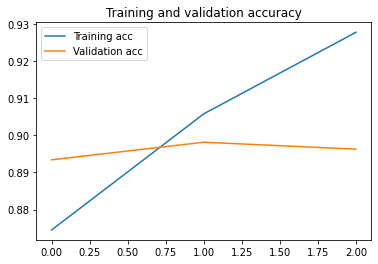

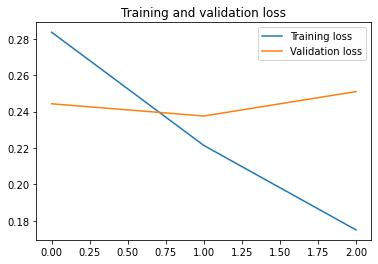

In [21]:
charts.show()

In [22]:
train.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:Collective batch_all_reduce: 200 all-reduces, num_devices = 2, group_size = 2, communication_hint = AUTO, num_packs = 1
INFO:tensorflow:Collective batch_all_reduce for IndexedSlices: 1 all-reduces, group_size = 2
/home/fyp5/anaconda3/envs/afe/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
INFO:tensorflow:Collective batch_all_reduce: 1 all-redu

In [ ]:
import csv
with open('output/extracted_importance_bert_resample.csv', 'w') as ofile:
    csv_writer = csv.writer(ofile, delimiter=',', quotechar='"')
    csv_writer.writerow(list(data_files.columns)[:-1])
    for idx, predict in zip(prediction_index, prediction):
        csv_writer.writerow(idx + list(predict>0.5))
# empty_pred.to_csv('output/extracted_importance_bert_resample.csv', mode='a', header=False, index=False)